# Performing PLD/PCA analysis on NIRCam/LW data

We have shown elsewhere that performing PCA on pixel-level lightcurves on NIRCam/SW data is a very good way to sense change in PSF (mainly caused by mirror tilting events). It was also suggested that such mirror tilting events can cause change in the LW PSF. One way to detect this change is to look at the FWHM of LW data. We also did that but found nothing significant. In this notebook, we will try to do PCA on LW data and see if we can find anything. The method that we are going to use is qualitatively the same as we used for SW data.

_Acknowledgements_: The algorithm used here is described in various literature, e.g., [Luger et al. 2016](https://www.doi.org/10.3847/0004-6256/152/4/100). The core code used in the present notebook was developed by Néstor Espinoza to extract photometry from TESS TPF files which can be found [here](https://github.com/nespinoza/PLD-TESS), which was then used by Jayshil A. Patel to extract lightcurves from [TESS/TICA data](https://github.com/Jayshil/tess-tica). We modified that code to work with JWST data in the present work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from poetss import poetss
import os
from tqdm import tqdm
from astropy.stats import mad_std

In [2]:
visit = 'NRCLW'

p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Corr_' + visit
pout = p1 + '/' + visit + '/Outputs/' + visit

segs = []
for i in range(6):
    if i < 9:
        segs.append('00' + str(i+1))
    else:
        segs.append('0' + str(i+1))

corrected_data_wRef = np.load(pin + '/Corrected_data_seg' + segs[0] + '.npy')
for i in range(len(segs)-1):
    ## Data
    data1 = np.load(pin + '/Corrected_data_seg' + segs[i+1] + '.npy')
    corrected_data_wRef = np.vstack((corrected_data_wRef, data1))

corrected_data = corrected_data_wRef[:,4:,:]
nint = np.random.randint(0, corrected_data.shape[0])

Our first task is to generate aperture mask so that we can determine how many pixels we want to use in the analysis. For this we will first find trace positions on the detector, then we will use all pixels within the range of 5 pixels from the trace in the analysis.

Let's first find trace position and then use it to define aperture mask.

Text(0.5, 1.0, 'Aperture Mask')

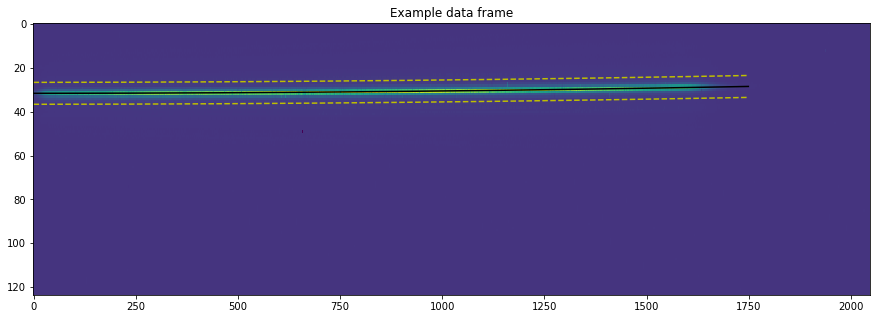

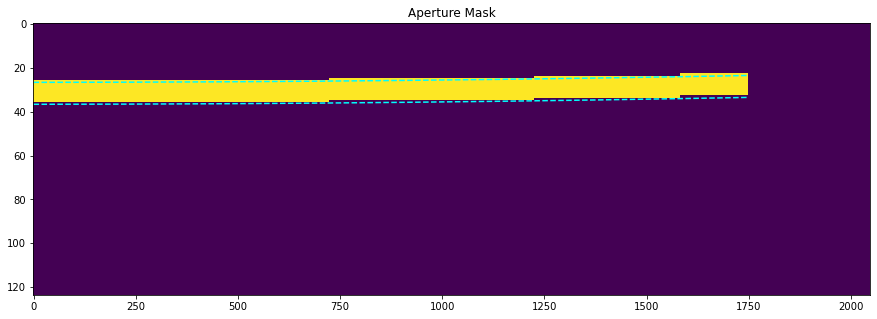

In [3]:
# Finding trace
cent_cub1 = poetss.find_trace_cof(clean_cube=corrected_data[:,:,0:1750], margin=5)
trace1, dx1 = poetss.fit_multi_trace(cent_mat=cent_cub1, deg=2, clip=3)
xpos = np.arange(0, 1750, 1)

aperture_mask = np.zeros(corrected_data[0,:,:].shape)
for i in range(len(xpos)):
    aperture_mask[int(trace1[i]-5):int(trace1[i]+5), xpos[i]] = 1

plt.figure(figsize=(15,5))
plt.imshow(corrected_data[nint,:,:], interpolation='none', aspect='auto')
plt.plot(xpos, trace1, 'k-')
plt.plot(xpos, trace1-5, ls='--', color='y')
plt.plot(xpos, trace1+5, ls='--', color='y')
plt.title('Example data frame')

plt.figure(figsize=(15,5))
plt.imshow(aperture_mask, interpolation='none', aspect='auto')
plt.plot(xpos, trace1-5, ls='--', color='cyan')
plt.plot(xpos, trace1+5, ls='--', color='cyan')
plt.title('Aperture Mask')

Alright! This should work. We will use every pixels inside the yellow region in our analysis.

Now, let's generate pixel flux, i.e., lightcurves for each pixels inside the aperture. We will do this by computing $\hat{P} \equiv P_i(t) / \Sigma_i P_i(t)$. We will then perform PCA analysis on these fluxes.

In [4]:
pixel_fluxes = np.zeros((corrected_data.shape[0], int(np.sum(aperture_mask))))

# Location of aperture pixels
idxr, idxc = np.where(aperture_mask == 1)
# And, now saving pixel fluxes
for i in tqdm(range(len(idxr))):
    pixel_fluxes[:,i] = corrected_data[:,idxr[i],idxc[i]]

# First defining Phat
Phat = np.zeros(pixel_fluxes.shape)
Psum = np.sum(pixel_fluxes,axis=1)

for i in range(Phat.shape[0]):
    Phat[i,:] = pixel_fluxes[i,:]/Psum[i]

100%|██████████| 17500/17500 [00:00<00:00, 40407.40it/s]


One of the reason we need PCA is because these pixel-level lightcurves containts a lot of rudimentary information, which we can see from the correlation plot below:

Text(0, 0.5, 'Element $j$')

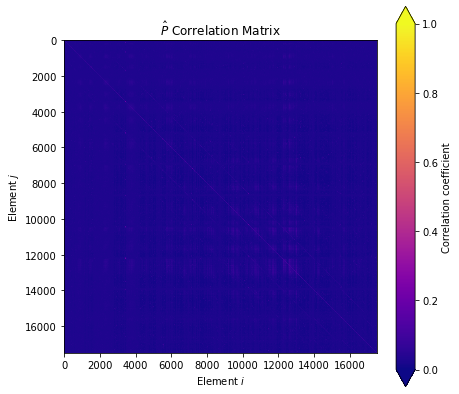

In [5]:
CorrelationMatrix = np.abs(np.corrcoef(Phat.T))

plt.figure(figsize=(7,7))
plt.title('$\hat{P}$ Correlation Matrix')
im = plt.imshow(CorrelationMatrix, cmap='plasma')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

It is hard to see, but yes, there are some non-zero off-diagonal elements present in the data. So, now let's perform PCA analysis:

In [6]:
def standarize_data(input_data):
    """
    Standarize the dataset
    """
    output_data = np.copy(input_data)
    averages = np.median(input_data,axis=1)
    for i in range(len(averages)):
        sigma = mad_std(output_data[i,:])
        output_data[i,:] = output_data[i,:] - averages[i]
        output_data[i,:] = output_data[i,:]/sigma
    return output_data

def classic_PCA(Input_Data, standarize = True):
    """  
    classic_PCA function
    Description
    This function performs the classic Principal Component Analysis on a given dataset.
    """
    if standarize:
        Data = standarize_data(Input_Data)
    else:
        Data = np.copy(Input_Data)
    eigenvectors_cols,eigenvalues,eigenvectors_rows = np.linalg.svd(np.cov(Data))
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx[::-1]]
    eigenvectors_cols = eigenvectors_cols[:,idx[::-1]]
    eigenvectors_rows = eigenvectors_rows[idx[::-1],:]
    # Return: V matrix, eigenvalues and the principal components.
    return eigenvectors_rows,eigenvalues,np.dot(eigenvectors_rows,Data)

V, eigenvalues, PCA = classic_PCA(Phat.T)

Did correlation matrix change?

Text(0, 0.5, 'Element $j$')

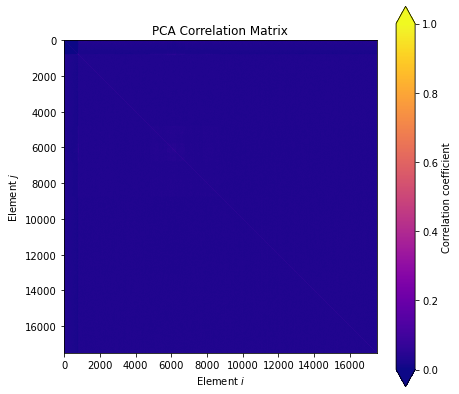

In [7]:
PCACorrelationMatrix = np.abs(np.corrcoef(PCA))

plt.figure(figsize=(7,7))
plt.title('PCA Correlation Matrix')
im = plt.imshow(PCACorrelationMatrix,cmap='plasma')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

Looks like it did make the correlation matrix diagonal. Now, let's look at the eigenvalues,

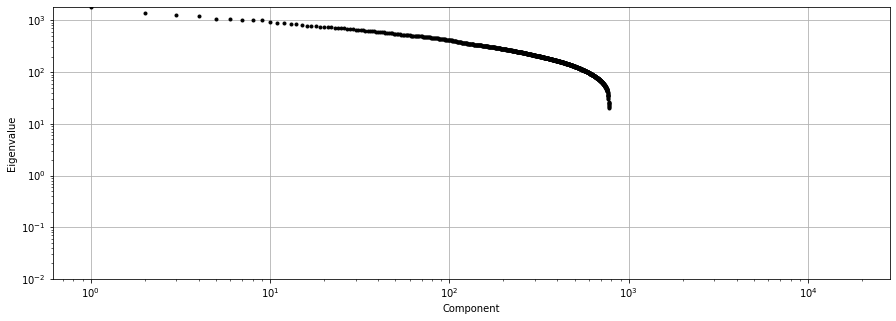

In [8]:
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(len(eigenvalues))+1, eigenvalues, fmt='.', c='k')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,np.max(eigenvalues)])
plt.grid()

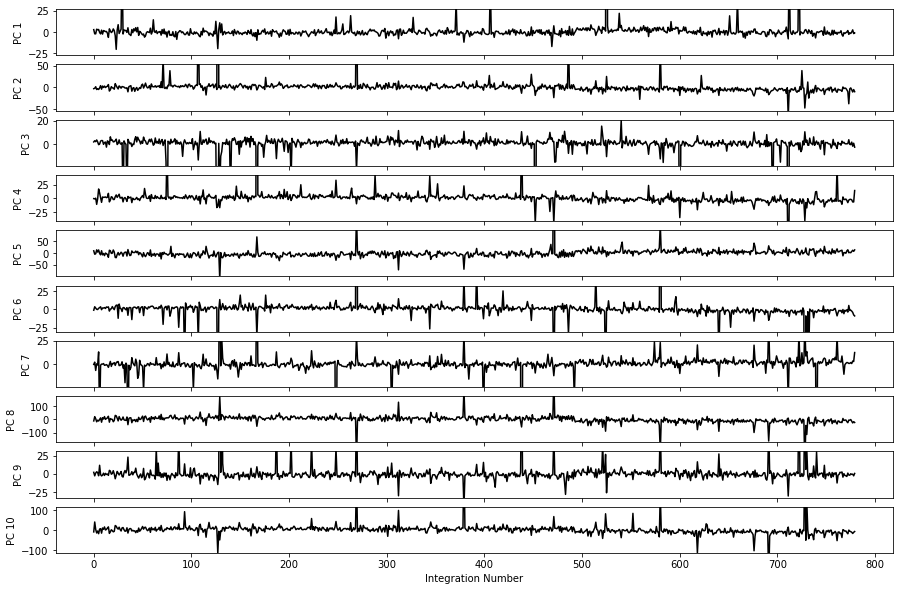

In [9]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(15,10), sharex=True)
for i in range(10):
    axs[i].plot(np.arange(corrected_data.shape[0]), PCA[i,:], 'k-')
    axs[i].set_ylabel('PC ' + str(i+1))
    med, std = np.nanmedian(PCA[i,:]), mad_std(PCA[i,:])
    axs[i].set_ylim([med-10*std, med+10*std])
plt.xlabel('Integration Number')

np.save(pout + '/PCs.npy', PCA)

There may be some minor jumps detected in the PCs, but nothing obvious was found.